In [3]:
import pandas as pd

In [4]:

df = pd.read_csv('recons-our-bma.csv')


In [5]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCTCCGTTGTATCTA...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGAAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...


In [6]:
from tqdm import tqdm


In [7]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [8]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [9]:
import difflib


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [11]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 66968.93it/s]


[23, 148, 148, 178, 202, 234, 262, 290, 309, 315, 321, 371, 388, 402, 408, 444, 491, 505, 508, 568, 570, 610, 613, 647, 665, 694, 731, 710, 745, 776, 787, 813, 840, 851, 862, 882, 903, 915, 951, 998, 994, 1022, 1024, 1087, 1090, 1103, 1098, 1158, 1162, 1220, 1211, 1206, 1221, 1256, 1975, 1964, 1923, 1915, 1915, 1912, 1848, 1839, 1846, 1805, 1847, 1739, 1742, 1712, 1673, 1712, 1674, 1646, 1652, 1631, 1600, 1591, 1552, 1564, 1527, 1519, 1503, 1455, 1441, 1404, 1421, 1405, 1337, 1359, 1320, 1263, 1284, 1295, 1265, 1223, 1246, 1186, 1156, 1133, 1174, 1075, 1083, 1095, 1094, 1047, 1014, 1004, 1006, 1108, 741, 731]


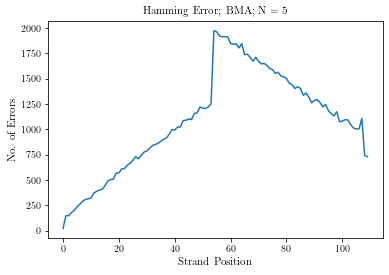

In [12]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; BMA; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-our-bma-hamming.pdf', bbox_inches='tight')

In [13]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:05<00:00, 1710.03it/s]


In [14]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


 -> AAA 6
A -> GC 6
C -> GG 6
G -> AC 6
A -> GT 6
TCA ->  6
C -> TT 7
A -> GG 7
A -> TT 7
G -> TC 8
C -> AA 9
T -> AC 9
T -> CA 10
G -> TT 11
A -> TC 11
T -> GG 12
G -> AA 13
T -> AA 14
CC ->  14
GG ->  14
TT ->  15
AA ->  17
T -> CC 20
GC ->  22
G -> CC 23
AG ->  23
CG ->  25
 -> AG 25
AC ->  25
TG ->  26
 -> AT 26
 -> GA 27
GA ->  28
CT ->  29
 -> GC 30
GT ->  32
 -> CT 32
 -> CG 32
TC ->  32
A -> CC 33
TA ->  33
 -> GT 34
AT ->  35
 -> AA 36
 -> TG 36
 -> TC 37
 -> CA 38
 -> CC 38
 -> AC 39
 -> TA 40
 -> TT 42
 -> GG 43
CA ->  49
G -> T 228
C -> T 235
C -> G 236
G -> A 238
A -> G 244
C -> A 249
A -> T 280
T -> G 288
T -> A 333
G -> C 340
T -> C 421
A -> C 425
 -> T 822
 -> G 889
 -> A 909
 -> C 968
C ->  1017
A ->  1087
G ->  1101
T ->  1217


C ->  @ 40 6
 -> T @ 66 6
G ->  @ 72 6
A ->  @ 47 6
T ->  @ 12 6
A ->  @ 12 6
 -> T @ 61 6
T -> C @ 58 6
G -> T @ 60 6
T -> C @ 55 6
T -> G @ 104 6
A ->  @ 63 6
 -> C @ 78 6
G ->  @ 84 6
 -> AT @ 55 6
A -> G @ 109 6
G ->  @ 37 6
C ->  @ 33 6
 -> CG @ 55 6
T ->  @ 99 6
T -> A @ 67 6
C ->  @ 106 6
T ->  @ 105 6
T -> G @ 102 6
G -> T @ 13 6
 -> A @ 22 6
T -> C @ 95 6
 -> A @ 100 6
G ->  @ 62 6
 -> TC @ 53 6
A ->  @ 20 6
A -> C @ 25 6
C ->  @ 20 6
 -> TA @ 55 6
C -> T @ 41 6
T -> C @ 87 6
C ->  @ 78 6
A ->  @ 27 6
G -> T @ 22 6
A ->  @ 29 6
G ->  @ 67 6
 -> T @ 28 6
G ->  @ 5 6
A ->  @ 15 6
G -> C @ 54 6
A ->  @ 33 6
A -> T @ 86 6
GT ->  @ 56 6
G ->  @ 50 6
G ->  @ 89 6
T -> A @ 54 6
G -> T @ 54 6
C ->  @ 27 6
T -> C @ 68 6
A -> C @ 2 6
 -> C @ 74 6
C ->  @ 71 6
G ->  @ 26 6
 -> A @ 38 6
A -> C @ 53 6
T ->  @ 81 6
G ->  @ 13 6
G ->  @ 12 6
C ->  @ 63 6
 -> GA @ 53 6
G ->  @ 15 6
G ->  @ 11 6
G -> T @ 91 6
C ->  @ 58 6
A ->  @ 93 6
 -> C @ 46 6
 -> C @ 45 6
A ->  @ 66 6
A -> C @ 70 6
A ->  

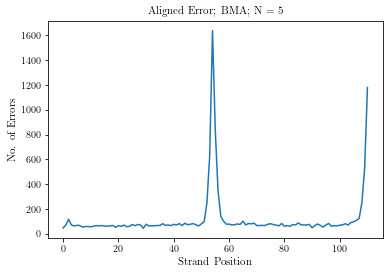

In [15]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; BMA; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-our-bma-aligned.pdf', bbox_inches='tight')

In [16]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [17]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [18]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 15, 10, 6, 7, 6, 8, 7, 6, 7, 10, 4, 6, 6, 3, 7, 4, 5, 3, 2, 9, 9, 13, 6, 4, 4, 5, 6, 7, 5, 13, 5, 3, 6, 8, 4, 9, 5, 5, 3, 10, 10, 5, 8, 8, 7, 9, 10, 7, 8, 7, 10, 14, 25, 83, 104, 28, 11, 12, 5, 4, 5, 8, 10, 10, 3, 6, 6, 7, 6, 4, 7, 4, 7, 10, 8, 4, 9, 7, 10, 1, 6, 10, 7, 5, 12, 7, 9, 5, 10, 8, 6, 7, 10, 4, 6, 6, 10, 9, 6, 9, 7, 11, 9, 11, 6, 11, 10, 25, 51, 156]
[0, 8, 14, 6, 10, 6, 5, 4, 1, 2, 3, 6, 6, 6, 9, 6, 6, 5, 7, 4, 7, 4, 4, 8, 5, 8, 6, 6, 8, 2, 5, 2, 5, 5, 8, 7, 11, 6, 2, 4, 8, 4, 8, 3, 5, 5, 8, 7, 10, 3, 6, 2, 13, 25, 71, 130, 29, 11, 5, 13, 7, 8, 6, 9, 3, 12, 8, 6, 5, 1, 8, 4, 6, 7, 6, 11, 8, 8, 7, 11, 12, 5, 2, 10, 6, 5, 8, 8, 7, 6, 2, 2, 7, 8, 4, 5, 11, 4, 5, 8, 4, 4, 8, 3, 8, 11, 14, 10, 25, 39, 116]
[0, 7, 12, 10, 5, 7, 3, 4, 6, 6, 5, 8, 6, 5, 8, 6, 2, 7, 3, 7, 6, 4, 5, 4, 8, 4, 9, 6, 2, 6, 5, 5, 3, 6, 8, 7, 7, 9, 7, 5, 4, 8, 8, 7, 9, 7, 7, 6, 2, 1, 1, 8, 14, 24, 84, 117, 29, 11, 7, 8, 3, 4, 4, 6, 9, 9, 6, 9, 14, 10, 4, 3, 7, 3, 2, 8, 5, 10, 6, 7, 2, 4, 4, 4, 8, 12, 4

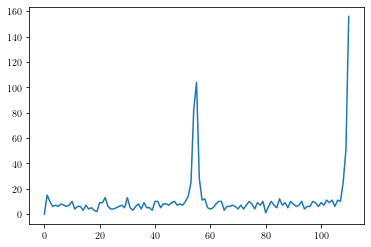

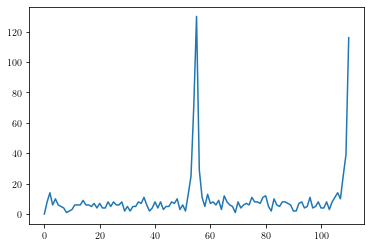

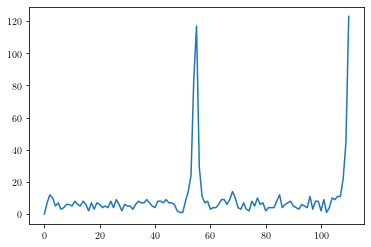

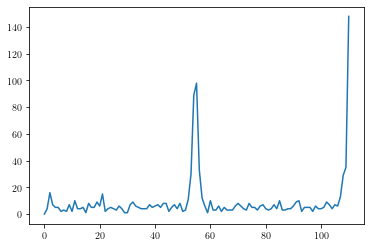

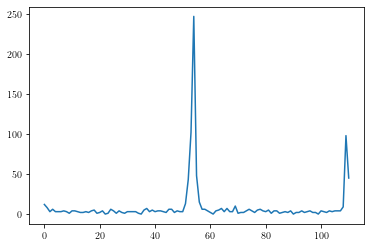

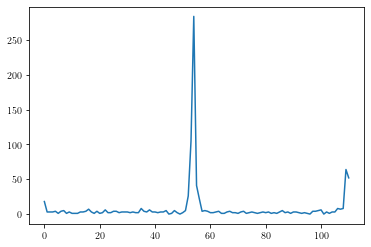

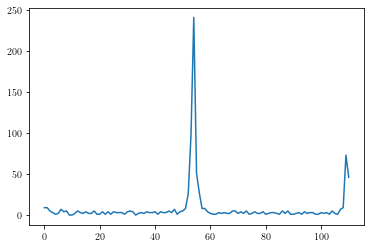

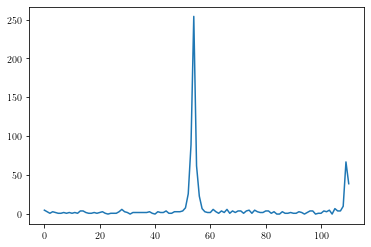

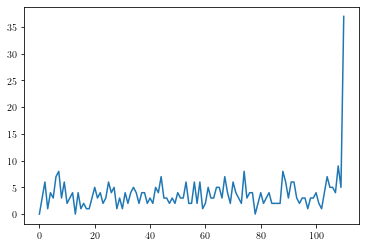

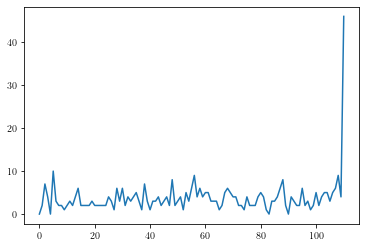

In [19]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [20]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)